### 1. អ៊ីមផត ផេកខេចសម្រាប់ ប្រូជេក

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

### 2. Load data set ( Use USvideo.csv)

In [17]:
df = pd.read_csv("../Data/USvideos.csv")

### EDA

In [18]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [19]:
df.shape

(40949, 16)

In [20]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


In [21]:
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

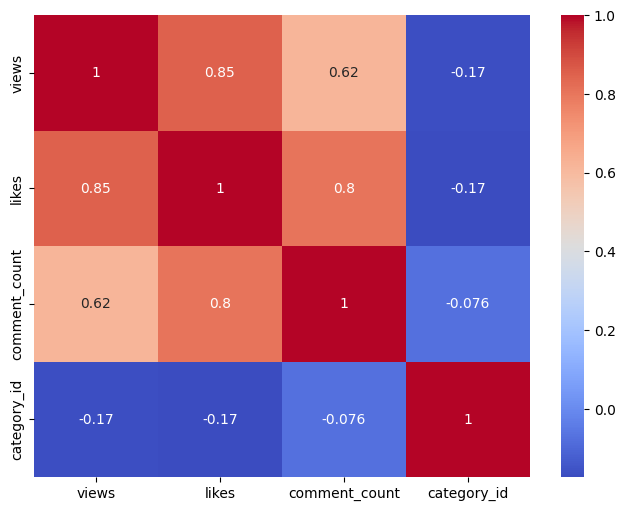

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(df[["views","likes","comment_count","category_id"]].corr(), annot=True, cmap="coolwarm")
plt.show()


### 3. Cleaning data and Preprocessing

In [24]:
# Convert publish_time to datetime
df["publish_time"] = pd.to_datetime(df["publish_time"], errors="coerce")


In [25]:
# Extract publish hour
df["publish_hour"] = df["publish_time"].dt.hour

In [26]:
# Create engagement rate feature (likes per comment ratio)
df["engagement_rate"] = df["likes"] / (df["comment_count"] + 1)  # +1 to avoid division by zero

In [27]:
# Extract day of week (weekend videos may perform differently)
df["day_of_week"] = df["publish_time"].dt.dayofweek  # 0=Monday, 6=Sunday

In [28]:
# ​ជ្រើសរើស columns ដែលយើងត្រូវប្រើ
df = df[["views", "likes", "comment_count", "category_id",
         "channel_title", "publish_hour", "day_of_week", "engagement_rate"]]

In [29]:
# Drop rows with missing values
df = df.dropna()

### 4. Set target

In [30]:
X = df[["likes", "comment_count", "category_id",
        "channel_title", "publish_hour", "day_of_week", "engagement_rate"]]
y = df["views"]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 5. Prepaire 

In [40]:
# Categorical + numerical features
categorical_features = ["channel_title"]
numeric_features = ["likes", "comment_count", "category_id", "publish_hour", "day_of_week", "engagement_rate"]

In [33]:
# Encoder for text columns + Scaler for numeric columns
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ]
)


### 6. Make data pipeline for onehot encoding


In [34]:
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

In [35]:
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
y_pred = model.predict(X_test)

In [37]:
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}")
print(f"\nMean Actual Views: {y_test.mean():,.2f}")
print(f"Mean Predicted Views: {y_pred.mean():,.2f}")

R² Score: 0.8909
MAE: 783,360.33
RMSE: 2,291,710.46

Mean Actual Views: 2,347,343.14
Mean Predicted Views: 2,334,103.18


In [38]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Cross-Validation R² Scores: [0.92643868 0.87108334 0.89962578 0.90115043 0.90996248]
Mean CV R² Score: 0.9017 (+/- 0.0360)


### 7. Save the Model

In [41]:
# Save the trained model
joblib.dump(model, '../model_youtube_views.pkl')
print("Model saved as 'model_youtube_views.pkl'")

Model saved as 'model_youtube_views.pkl'
